In [23]:
import pandas as pd
import lightgbm as lgb

import os
import random
import pickle

from data import read_processed_train, read_processed_val, read_processed_test

In [24]:
# For testing use only 1000 rows
train_file = os.path.join('data', 'training_set_VU_DM.csv')
# df = pd.read_csv(train_file, nrows=5000)
df = pd.read_csv(train_file)
df.sample(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
4711756,316099,2013-04-08 19:09:27,5,219,NaN,NaN,219,33016,2,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3449811,231660,2013-04-04 17:23:51,5,219,NaN,NaN,219,10748,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3981016,267179,2013-02-14 14:23:26,24,216,NaN,NaN,31,1423,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2136810,143392,2013-01-11 13:08:38,14,100,NaN,NaN,55,6001,3,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4349475,291846,2013-03-26 18:41:40,5,219,NaN,NaN,219,139170,3,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [25]:
# Add relevance column
df['relevance'] = 0

mask = df['click_bool'] == 1
df.loc[mask, 'relevance'] = 1

mask = df['booking_bool'] == 1
df.loc[mask, 'relevance'] = 5

In [26]:
# Split into train and test
TRAIN_SPLIT = 0.8

srch_ids = df['srch_id'].unique()
random.shuffle(srch_ids)

# Train
train_ids = srch_ids[:int(len(srch_ids) * TRAIN_SPLIT)]
train_df = df[df['srch_id'].isin(train_ids)]
train_df = train_df.sort_values(by=['srch_id'])

# Validation
val_ids = srch_ids[int(len(srch_ids) * TRAIN_SPLIT):]
val_df = df[df['srch_id'].isin(val_ids)]
val_df = val_df.sort_values(by=['srch_id'])

In [27]:
# Prepare data for LambdaMART

# TODO: Re-add prop_id as a feature?
# TODO: Convert date_time to a usable feature instead of just dropping it
# TODO: Be careful of relevance datatype when we change formula (currently int)

# Creating a numpy array which contains the number of properties for each search query
train_group = train_df.groupby("srch_id")["srch_id"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train_df.drop(["srch_id", "prop_id", "date_time", "position", "click_bool", "booking_bool", "gross_bookings_usd", "relevance"], axis = 1)
# Relevance label for train
y_train = train_df['relevance'].astype(int)

# Repeating the same process for test data
val_group = val_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_val = val_df.drop(["srch_id", "prop_id", "date_time", "position", "click_bool", "booking_bool", "gross_bookings_usd", "relevance"], axis = 1)
y_val = val_df['relevance'].astype(int)

In [28]:
# Training

# Creating the ranker object
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    boosting_type = "gbdt",
    n_estimators = 100,
    # early_stopping_rounds = 50,
    importance_type = "gain",
    metric= "ndcg",
    num_leaves = 10,
    learning_rate = 0.02,
    max_depth = -1,
    label_gain =[i for i in range(max(y_train.max(), y_test.max()) + 1)])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=train_group,
      eval_set=[(X_train, y_train),(X_val, y_val)],
      eval_group=[train_group, val_group],
      eval_at=[50]
      )

[1]	training's ndcg@50: 0.438861	valid_1's ndcg@50: 0.438749
[2]	training's ndcg@50: 0.458972	valid_1's ndcg@50: 0.46093
[3]	training's ndcg@50: 0.467015	valid_1's ndcg@50: 0.468523
[4]	training's ndcg@50: 0.471808	valid_1's ndcg@50: 0.473424
[5]	training's ndcg@50: 0.475556	valid_1's ndcg@50: 0.478076
[6]	training's ndcg@50: 0.477209	valid_1's ndcg@50: 0.479041
[7]	training's ndcg@50: 0.478262	valid_1's ndcg@50: 0.479788
[8]	training's ndcg@50: 0.479624	valid_1's ndcg@50: 0.481319
[9]	training's ndcg@50: 0.482497	valid_1's ndcg@50: 0.483662
[10]	training's ndcg@50: 0.48352	valid_1's ndcg@50: 0.484744
[11]	training's ndcg@50: 0.483645	valid_1's ndcg@50: 0.484994
[12]	training's ndcg@50: 0.484874	valid_1's ndcg@50: 0.486194
[13]	training's ndcg@50: 0.485233	valid_1's ndcg@50: 0.486324
[14]	training's ndcg@50: 0.485487	valid_1's ndcg@50: 0.486101
[15]	training's ndcg@50: 0.486145	valid_1's ndcg@50: 0.486792
[16]	training's ndcg@50: 0.486943	valid_1's ndcg@50: 0.487423
[17]	training's ndc

LGBMRanker(importance_type='gain', label_gain=[0, 1, 2, 3, 4, 5],
           learning_rate=0.02, metric='ndcg', num_leaves=10,
           objective='lambdarank')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

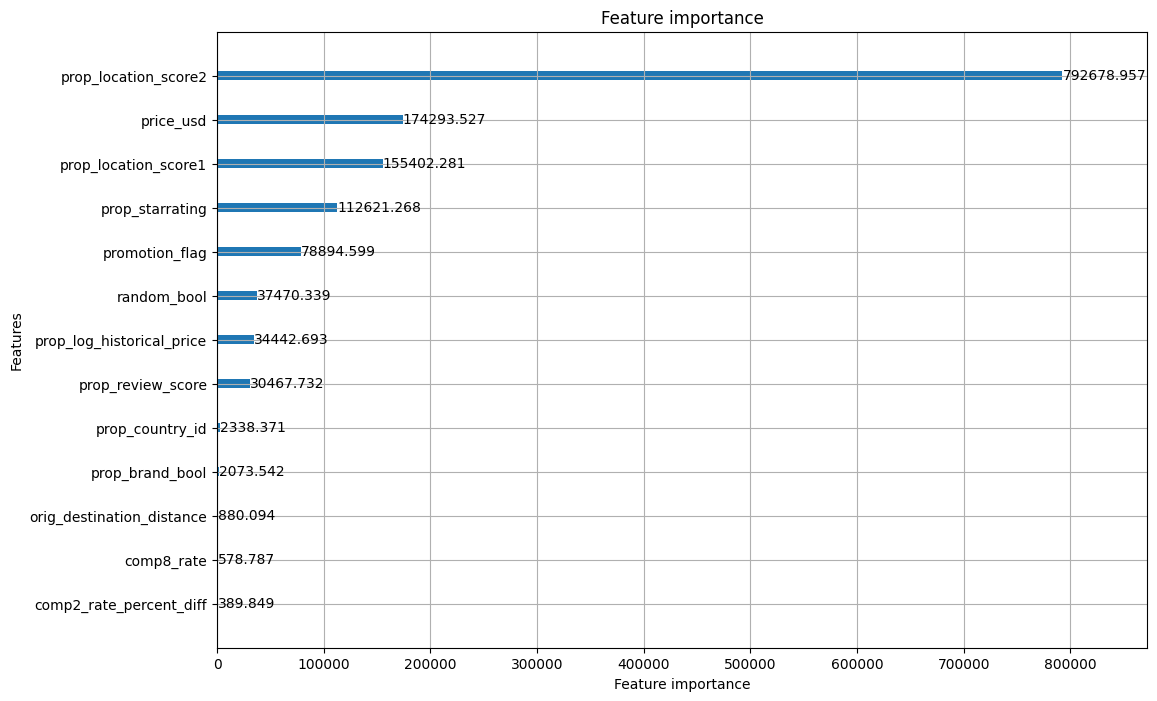

In [29]:
lgb.plot_importance(ranker, figsize = (12,8))

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@50'>

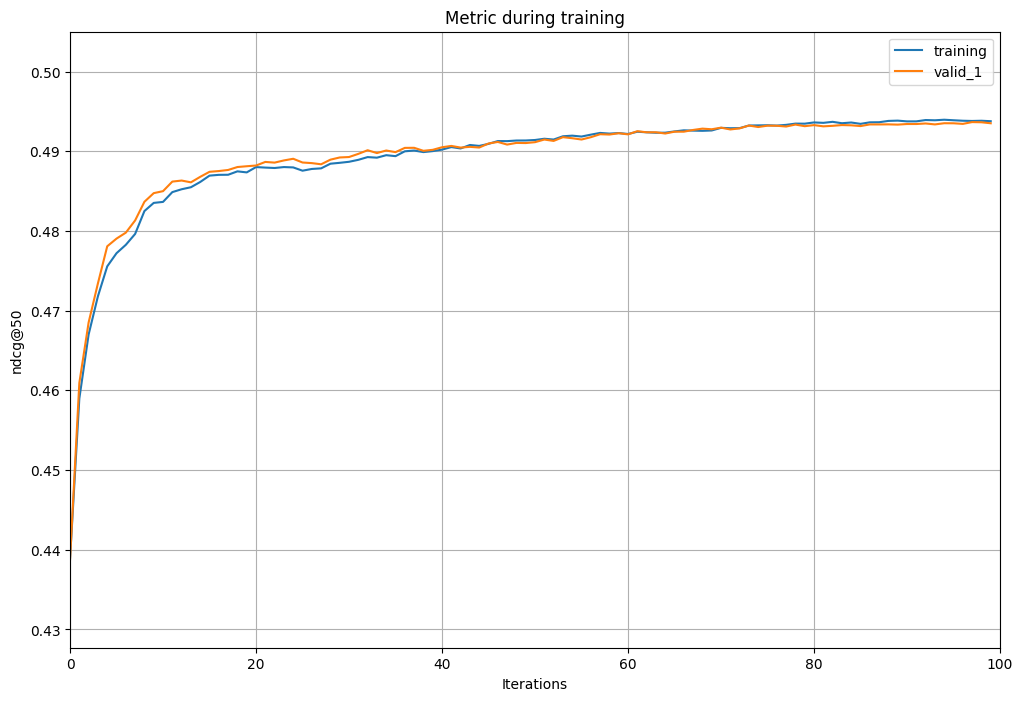

In [30]:
lgb.plot_metric(ranker, figsize = (12,8))

In [31]:
model_file = os.path.join('models', 'lambdamart1.pkl')
pickle.dump(ranker, open(model_file, 'wb'))

## Test

In [44]:
model_file = os.path.join('models', 'lambdamart1.pkl')
model = pickle.load(open(model_file, 'rb'))

In [40]:
test_file = os.path.join('data', 'test_set_VU_DM.csv')
test_df = pd.read_csv(test_file)
test_df.sample(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
4627092,310643,2013-04-05 20:03:53,5,219,NaN,NaN,219,137751,4,4.0,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4021722,270136,2013-05-22 09:49:34,5,219,NaN,NaN,219,35223,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2820427,189811,2013-04-05 16:40:01,5,219,NaN,NaN,205,130646,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4044023,271684,2012-11-25 22:48:07,24,216,NaN,NaN,92,50608,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4186307,281115,2013-01-15 18:22:33,5,219,NaN,NaN,219,91261,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [43]:
features = list(test_df.columns)
features.remove('srch_id')
features.remove('date_time')
features.remove('prop_id')

X_test = test_df[features].to_numpy(copy=True)

In [45]:
# Predict
test_pred = model.predict(X_test)

In [46]:
test_df['test_pred'] = test_pred
# Sort by srch_id and test_pred
test_df = test_df.sort_values(by=['srch_id', 'test_pred'], ascending=[True, False])
test_df[['srch_id', 'prop_id', 'test_pred']].head(100)


,srch_id,prop_id,test_pred
23,1,99484,0.326909
9,1,54937,0.321081
12,1,61934,0.249026
5,1,28181,0.195908
4,1,24194,0.169590
...,...,...,...
112,10,92193,0.204525
113,10,94138,0.182497
99,10,37616,0.175077
111,10,90052,0.136737


In [50]:
final_df = test_df[['srch_id', 'prop_id']]

submission_file = os.path.join('submissions', 'submission.csv')
final_df.to_csv(submission_file, index=False)

In [51]:
final_df.shape

(4959183, 2)